# Implementasi Algoritma Long Short Term Memory untuk Memprediksi Harga Mata Uang Kripto Litecoin

## 1. Import Library Python yang Dibutuhkan

In [4]:
# Library utama
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import seaborn as sb
import warnings

# Library untuk Evaluasi
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Library untuk Plot dan Grafik
import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Library untuk Algoritma Long Short Term Memory
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

## 2. Memuat dan Menganalisis Dataset

### A. membaca data

In [5]:
# Memuat dataset dari directory /Data

maindf=pd.read_csv('Data/LTC-USD LSTM.csv')
maindf.shape

(763, 7)

In [6]:
maindf.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-03-01,113.476082,115.579834,110.730995,112.544044,112.544044,951568702
1,2022-03-02,112.540298,114.243759,109.672516,110.351357,110.351357,838169853
2,2022-03-03,110.356354,112.503716,108.962349,111.352119,111.352119,905649306
3,2022-03-04,111.412834,112.356232,100.207321,101.391800,101.391800,930473366
4,2022-03-05,101.408401,105.351410,100.218079,104.977188,104.977188,548783174


In [7]:
maindf.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
758,2024-03-28,93.675514,96.385338,93.524315,94.219116,94.219116,702908138
759,2024-03-29,94.219017,110.005928,93.110497,109.258972,109.258972,1803906237
760,2024-03-30,109.243942,109.249985,101.306541,102.863113,102.863113,729886796
761,2024-03-31,102.866302,106.548813,101.554459,105.183403,105.183403,638798519
762,2024-04-01,105.183403,112.315865,97.518333,99.375343,99.375343,1354224503


In [8]:
maindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763 entries, 0 to 762
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       763 non-null    object 
 1   Open       763 non-null    float64
 2   High       763 non-null    float64
 3   Low        763 non-null    float64
 4   Close      763 non-null    float64
 5   Adj Close  763 non-null    float64
 6   Volume     763 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 41.9+ KB


In [9]:
maindf.describe()

,Open,High,Low,Close,Adj Close,Volume
count,763.000000,763.000000,763.000000,763.000000,763.000000,7.630000e+02
mean,76.829883,78.683373,74.888649,76.811362,76.811362,5.535808e+08
std,17.692377,18.053798,17.244829,17.663570,17.663570,3.081555e+08
min,43.314003,46.132015,40.680405,43.300301,43.300301,1.207859e+08
25%,63.602983,64.907093,62.083876,63.604105,63.604105,3.540621e+08
50%,72.650223,74.262314,70.888885,72.650749,72.650749,4.939219e+08
75%,90.464138,92.130532,87.916675,90.466953,90.466953,6.747860e+08
max,131.166367,133.906784,127.852745,131.169342,131.169342,3.377766e+09


### B. Memeriksa Null dalam Dataset

In [10]:
print('Null Values:',maindf.isnull().values.sum())
print('NA values:',maindf.isnull().values.any())

Null Values: 0
NA values: False


In [11]:
maindf.shape

(763, 7)

### C. Analisis Deskriptif

In [12]:
# Memeriksa kapan tanggal data dimulai dan tanggal data berakhir
sd=maindf.iloc[0][0]
ed=maindf.iloc[-1][0]

print('Starting Date',sd)
print('Ending Date',ed)

Starting Date 2022-03-01
Ending Date 2024-04-01


<ipython-input-12-8b88e3ebff00>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sd=maindf.iloc[0][0]
<ipython-input-12-8b88e3ebff00>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ed=maindf.iloc[-1][0]


#### - Analisis Keseluruhan data dari tahun 2022 - tahun 2024

In [13]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_overall = maindf.loc[(maindf['Date'] >= '2022-03-01')
                     & (maindf['Date'] <= '2024-04-01')]

y_overall.drop(y_overall[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
0,2022-03-01,113.476082,115.579834,110.730995,112.544044
1,2022-03-02,112.540298,114.243759,109.672516,110.351357
2,2022-03-03,110.356354,112.503716,108.962349,111.352119
3,2022-03-04,111.412834,112.356232,100.207321,101.391800
4,2022-03-05,101.408401,105.351410,100.218079,104.977188
...,...,...,...,...,...
758,2024-03-28,93.675514,96.385338,93.524315,94.219116
759,2024-03-29,94.219017,110.005928,93.110497,109.258972
760,2024-03-30,109.243942,109.249985,101.306541,102.863113
761,2024-03-31,102.866302,106.548813,101.554459,105.183403


In [14]:
names = cycle(['LTC Open Price','LTC Close Price','LTC High Price','LTC Low Price'])

fig = px.line(y_overall, x=y_overall.Date, y=[y_overall['Open'], y_overall['Close'],
                                          y_overall['High'], y_overall['Low']],
             labels={'Date': 'Date','value':'Harga dalam USD'})
fig.update_layout(title_text='Bagan Analisis Litecoin(Keseluruhan)', font_size=14, font_color='black',legend_title_text='Parameter Litecoin')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

## 3. Preprocessing Data

### A. Mengambil Parameter Close Price dan Date dari data

In [15]:
# Pertama, Mengambil data Close Price(Harga petutupan)
closedf = maindf[['Date','Close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (763, 2)


In [16]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'Date':'Date','Close':'LTC Close'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Seluruh periode jangka waktu harga penutupan Litecoin Maret 2022- April 2024', plot_bgcolor='white',
                  font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [17]:
closedf = closedf[closedf['Date'] > '2022-03-30']
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])
closedf

Total data for prediction:  733


,Date,Close
30,2022-03-31,123.716011
31,2022-04-01,124.883179
32,2022-04-02,124.923485
33,2022-04-03,128.946213
34,2022-04-04,124.861702
...,...,...
758,2024-03-28,94.219116
759,2024-03-29,109.258972
760,2024-03-30,102.863113
761,2024-03-31,105.183403


In [18]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'Date':'Date','Close':'LTC Close'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Close Price LTC berdasarkan periode waktu yang akan di prediksi',
                  plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

### B. Normalisasi Data

In [19]:
# Step 1: Menghapus Kolom Date atau tanggal
del closedf['Date']

# Step 2: Proses Normalisasi menggunakan MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
closedf_normalized = scaler.fit_transform(closedf)

# Step 3: Ubah data yang dinormalisasi kembali ke DataFrame
closedf_normalized_df = pd.DataFrame(closedf_normalized, columns=closedf.columns)

# Step 4: buat data yang sudah di normalisasi dari data frame ke excel
excel_file_path = 'normalized_data.xlsx'
closedf_normalized_df.to_excel(excel_file_path, index=False)

print(f"Normalized data has been saved to: {excel_file_path}")

Normalized data has been saved to: normalized_data.xlsx


In [20]:
normaldf=pd.read_excel('normalized_data.xlsx')
normaldf

,Close
0,0.938932
1,0.952560
2,0.953031
3,1.000000
4,0.952309
...,...
728,0.594527
729,0.770132
730,0.695454
731,0.722546


### C. Membagi Data ke Data Uji dan Data Latih

In [21]:
# Data latih sebanyak 70% dan Data testing sebanyak 30%
training_size=int(len(closedf_normalized)*0.70)
test_size=len(closedf_normalized)-training_size
train_data,test_data=closedf_normalized[0:training_size,:],closedf_normalized[training_size:len(closedf_normalized),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (513, 1)
test_data:  (220, 1)


### D. Transformasi Data

In [22]:
# konversikan array nilai menjadi matriks kumpulan data
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [23]:
time_step = 10
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (502, 10)
y_train:  (502,)
X_test:  (209, 10)
y_test (209,)


In [24]:
# membentuk ulang input menjadi [samples, time steps, features] yang diperlukan untuk LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (502, 10, 1)
X_test:  (209, 10, 1)


## 4. Analisis Menggunakan Allgoritma LSTM

In [25]:
#menentukan model, neuron, loss, dan optimizer
model=Sequential()

model.add(LSTM(10,input_shape=(None,1),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [26]:
#menentukan epoch dan batch size
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=500,batch_size=64,verbose=1)

Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.2922 - val_loss: 0.1746
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2550 - val_loss: 0.1536
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2372 - val_loss: 0.1343
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2073 - val_loss: 0.1160
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1756 - val_loss: 0.0981
Epoch 6/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1532 - val_loss: 0.0797
Epoch 7/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1268 - val_loss: 0.0592
Epoch 8/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0938 - val_loss: 0.0345
Epoch 9/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0547 - val_loss: 0.0116
Epoch 10/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0177 - val_loss: 0.0047
Epoch 11/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0118 - val_loss: 0.0049
Epoch 12/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0091 - val_los

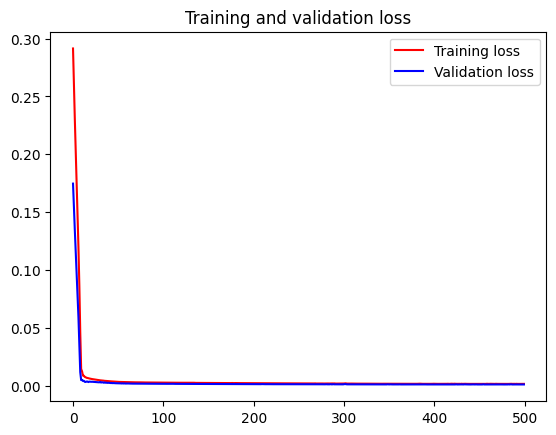

<Figure size 640x480 with 0 Axes>

In [27]:
# Proses Plotting Loss dan Validasi Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [28]:
#Lakukan prediksi dan periksa Performence metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


((502, 1), (209, 1))

### - Mengubah kembali model ke angka semula dari yang sebelumnya ter-normalisasi(denormalisasi)

In [29]:
# Ubah kembali ke bentuk Original
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

### - Perbandingan harga penutupan Litecoin asli dengan prediksi harga penutupan

In [30]:
# Proses plotting untuk data latih
look_back=time_step
trainPredictPlot = np.empty_like(closedf_normalized)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# Proses PLotting untuk data uji
testPredictPlot = np.empty_like(closedf_normalized)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf_normalized)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Data Harga Asli','Data Harga(berdsasarkan data latih)','Data Harga(berdsasarkan data Uji)'])


plotdf = pd.DataFrame({'Date': close_stock['Date'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['Date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Harga Litecoin($)','Date': 'Date'})
fig.update_layout(title_text='Komparasi dari Harga Penutupan asli dengan Harga Penutupan Hasil Prediksi',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (733, 1)
Test predicted data:  (733, 1)


In [31]:
# Assuming the DataFrame is named 'plotdf'
# Create a new DataFrame with the relevant columns
predicted_vs_actual = plotdf[['Date',
                              'original_close',
                              'train_predicted_close',
                              'test_predicted_close']]

# Save the new DataFrame to a xlsx file
predicted_vs_actual.to_excel('predicted_vs_actual.xlsx', index=False)
print(f"predicted_vs_actual data has been saved")

predicted_vs_actual data has been saved


## 5. Evaluasi Prediksi

### A. Evaluasi Matriks MSE dan RMSE

In [32]:
# Evaluasi matriks RMSE, MSE, dan MAE
print("Data Latih MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Data Latih RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("-------------------------------------------------------------------------------------")
print("Data Uji MSE: ", mean_squared_error(original_ytest,test_predict))
print("Data Uji RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))

Data Latih MSE:  10.648507820667355
Data Latih RMSE:  3.263205145354388
-------------------------------------------------------------------------------------
Data Uji MSE:  7.200793125553062
Data Uji RMSE:  2.6834293591509097


### B. Evaluasi Matriks R-Square

In [33]:
print("Data Latih R2 score:", r2_score(original_ytrain, train_predict))
print("Data Uji R2 score:", r2_score(original_ytest, test_predict))

Data Latih R2 score: 0.964667403362661
Data Uji R2 score: 0.9137495113003236


### B. Kesimpulan Hasil Nilai Evaluasi

In [34]:
mse=mean_squared_error(original_ytest,test_predict)
r2=r2_score(original_ytest, test_predict)

rmse = np.sqrt(mse)
mean_value = np.mean(original_ytest)
rmse_percentage = (rmse / mean_value) * 100

print("RMSE: ",rmse)
print("RMSE dalam persentase: {:.2f}%".format(rmse_percentage))
print("-------------------------------------------------------------------------------------")
print("R-Squared:", r2)
print("R-Squared dalam persentase: {:.2f}%".format(r2 * 100))

RMSE:  2.6834293591509097
RMSE dalam persentase: 3.72%
-------------------------------------------------------------------------------------
R-Squared: 0.9137495113003236
R-Squared dalam persentase: 91.37%


## 6. Implementasi

In [35]:
#Percobaan untuk memprediksi 7 hari kedepan
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 7
while(i<pred_days):

    if(len(temp_input)>time_step):

        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)

        lst_output.extend(yhat.tolist())
        i=i+1

    else:

        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())

        lst_output.extend(yhat.tolist())
        i=i+1

print("Hari yang akan diprediksi berjumlah: ", len(lst_output))

Hari yang akan diprediksi berjumlah:  7


In [36]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10]
[11 12 13 14 15 16 17]


In [37]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf_normalized[len(closedf_normalized)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Harga Penutupan 10 hari terakhir','Prediksi Harga Penutupan 7 Hari Kedepan'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'LTC Price','index': 'Timestamp'})
fig.update_layout(title_text='Komparasi 10 Hari Terakhir vs 7 Hari Kedepan',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Harga Penutupan')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [38]:
lstmdf=closedf_normalized.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'LTC price($)','index': 'Timestamp'})
fig.update_layout(title_text='Merencanakan seluruh harga penutupan LTC dengan prediksi',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Kripto')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()